In [64]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime


In [65]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['AAPL', 'MSFT', '^GSPC']

# We would like all available data from 10 month back (approx ~) 

end_date = datetime.datetime(2019, 10,19)
start_date = end_date - datetime.timedelta(days=(30 * 10))

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
df = data.DataReader('AAPL', 'yahoo', start_date, end_date)

In [66]:
df.shape

(207, 6)

In [67]:
close = df['Close']
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
# all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')
# close = close.reindex(all_weekdays)
# close = close.fillna(method='ffill')

In [68]:
close.head(10)

Date
2018-12-24    146.830002
2018-12-26    157.169998
2018-12-27    156.149994
2018-12-28    156.229996
2018-12-31    157.740005
2019-01-02    157.919998
2019-01-03    142.190002
2019-01-04    148.259995
2019-01-07    147.929993
2019-01-08    150.750000
Name: Close, dtype: float64

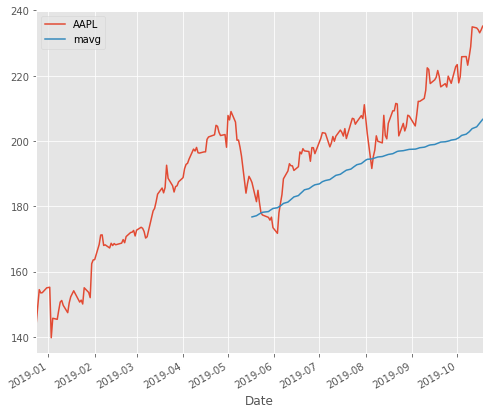

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [71]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2018-12-24,144.314041,37169200.0,3.378061,-0.890984
2018-12-26,154.476852,58582500.0,6.687023,5.981116
2018-12-27,153.474335,53117100.0,4.290744,0.198920
2018-12-28,153.552979,42291400.0,2.541126,-0.806352
2018-12-31,155.037109,35003500.0,1.825792,-0.498324


In [72]:
import math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split


# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

print(dfreg.shape)
# We want to separate 1 percent of the data to forecast
# forecast_out = int(math.ceil(0.1 * len(dfreg)))
forecast_out =60

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)
# dfreg.head(5)
X_lately.shape
# dfreg.head()

(207, 4)
Dimension of X (147, 4)
Dimension of y (147,)


(60, 4)

In [73]:
forecast_out

60

In [74]:
# Temp Space
int(math.ceil(0.001 * len(dfreg)))

1

In [75]:
# Separation of training and testing of model by cross validation train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [76]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X, y)


# # Quadratic Regression 2
# clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
# clfpoly2.fit(X_train, y_train)

# # Quadratic Regression 3
# clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
# clfpoly3.fit(X_train, y_train)
    
# # KNN Regression
# clfknn = KNeighborsRegressor(n_neighbors=2)
# clfknn.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [77]:
# confidencereg = clfreg.score(X_test, y_test)
# confidencepoly2 = clfpoly2.score(X_test,y_test)
# confidencepoly3 = clfpoly3.score(X_test,y_test)
# confidenceknn = clfknn.score(X_test, y_test)

# print("The linear regression confidence is ",confidencereg)
# print("The quadratic regression 2 confidence is ",confidencepoly2)
# print("The quadratic regression 3 confidence is ",confidencepoly3)
# print("The knn regression confidence is ",confidenceknn)

In [78]:
# Printing the forecast
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan
# print(forecast_set, confidencereg, forecast_out)

In [79]:
# dfreg.iloc[250].name
dfreg.columns
# X_lately.iloc[-1].name

Index(['Adj Close', 'Volume', 'HL_PCT', 'PCT_change', 'label', 'Forecast'], dtype='object')

In [80]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
#     print(next_date)
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
     

In [81]:
# dfreg.iloc[260]
# len(dfreg)
# forecast_set
dfreg.tail(155)

,Adj Close,Volume,HL_PCT,PCT_change,label,Forecast
Date,,,,,,
2019-06-06,183.531036,22526300.0,1.792467,1.168888,207.622437,NaN
2019-06-07,188.416077,30684400.0,3.234286,1.951638,204.598694,NaN
2019-06-10,190.823929,26220900.0,1.947243,0.401441,208.070038,NaN
2019-06-11,193.033585,26932900.0,1.231966,-0.025661,212.138123,NaN
2019-06-12,192.419250,18221800.0,1.328597,0.123746,212.118225,NaN
...,...,...,...,...,...,...
2019-12-13,NaN,NaN,NaN,NaN,NaN,224.255349
2019-12-14,NaN,NaN,NaN,NaN,NaN,224.969132
2019-12-15,NaN,NaN,NaN,NaN,NaN,223.714954


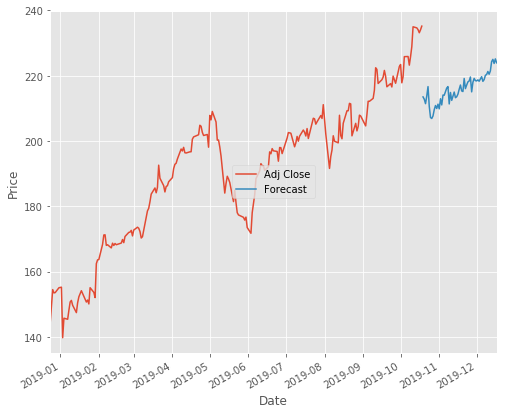

In [82]:
dfreg['Adj Close'].plot()
dfreg['Forecast'].plot()
plt.legend(loc=10)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [83]:

plt.show()